# Assignment 6: Viola&Jones
Read the paper by Viola and Jones. You can find it in "mycampus/resources/papers".

## Ex. 6.1 Rectangular Features
Implement the construction of all 2-rect features (horizontal and vertical) within a given window (like the 24x24 px window from the paper). How many exist? **(RESULT)** Display three of these overlaid onto an image of a face. **(RESULT)**

Number of features = 1152


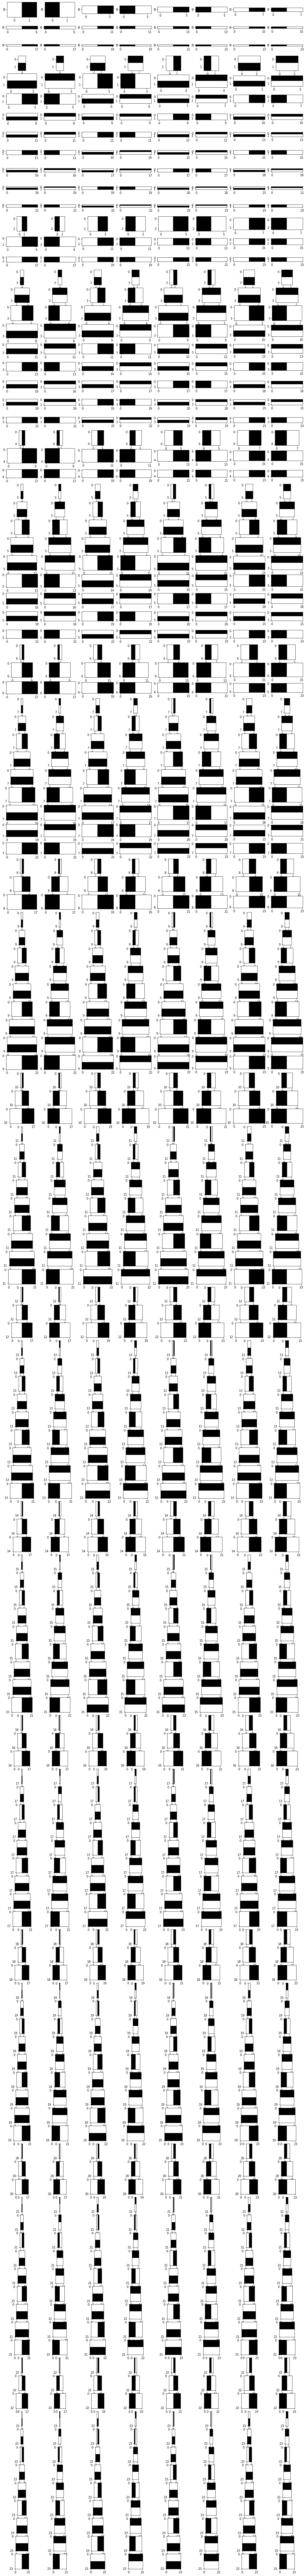

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io


"""
>>> np.concatenate([np.ones((3,3)), np.zeros((3,3))])
array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])
>>> np.concatenate([np.ones((3,3)), np.zeros((3,3))], axis=1)
array([[1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0.]])
"""

ones = np.ones
neg_ones = lambda shape: np.ones(shape) * -1


def get_2rect_mask(width, height, vertical, inverse):
    shape = (height, width)
    axis = 0 if vertical else 1
    seq = (
        (ones(shape), neg_ones(shape))
        if not inverse
        else (neg_ones(shape), ones(shape))
    )
    return np.concatenate(seq, axis=axis)

def get_all_2rect_masks(width, height):
    """
    :param width: Width of a SUB region (white OR black).
    :param height: Height of a SUB region (white OR black).
    """
    return (
        get_2rect_mask(width, height, vertical=True, inverse=False),
        get_2rect_mask(width, height, vertical=True, inverse=True),
        get_2rect_mask(width, height, vertical=False, inverse=False),
        get_2rect_mask(width, height, vertical=False, inverse=True),
    )
                   
def apply_mask(img, x, y, mask):
    height, width = mask.shape
    return img[y:(y + height), x:(x + width)] * mask

def feature_val(img, x, y, feature):
    return np.sum(apply_mask(img, x, y, feature))

                   
def construct_features(width, height, kind=2):
    def rect2(width, height):
        """
        We initially only compute the features such that
        the "white" area is only left for horizontally shaped
        and only top for vertically shaped areas.
        Finally, we add all flipped variants (of all results).
        
        The white area can max be half the size of the window.
        """
        features = []                   
        for y in range(1, height + 1):
            for x in range(1, width + 1):
                if x <= width // 2 or y <= height // 2:
                    features += get_all_2rect_masks(x, y)
        max_shape = np.array([height, width])
        return [
            feature 
            for feature in features
            if np.all(np.array(feature.shape) <= max_shape)
        ]
    
    if kind == 2:
        return rect2(width, height)
    raise NotImplementedError('Currently only 2-rect features are supported.')

    
two_rect_features = construct_features(24, 24)
print("Number of features =", len(two_rect_features))

fig = plt.figure(figsize=(18, 160), dpi=72)
fig.tight_layout()
for i, feature in enumerate(sorted(two_rect_features, key=lambda f: f.shape), start=1):
    ax = plt.subplot(144, 8, i)
    h, w = feature.shape
    ax.set_xticks([0, w - 1])
    ax.set_yticks([0, h - 1])
    ax.imshow(feature, cmap='gray', vmin=-1, vmax=1)
plt.savefig("06_features_2rect.png")

None

Feature coords and shapes:
6 10 (6, 10)
11 16 (8, 12)
13 0 (12, 11)


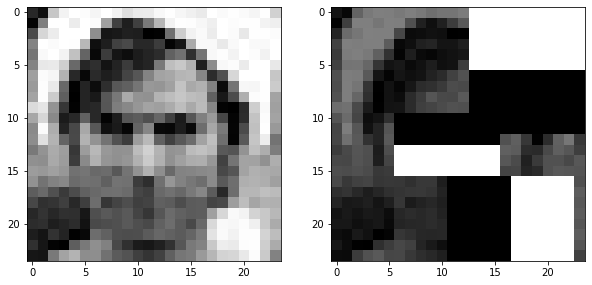

In [60]:
from collections import defaultdict
from multiprocessing import Pool

from skimage import io, color
from tqdm import tqdm


face_rgb = io.imread('images/face_taco.jpg')
face = color.rgb2gray(face_rgb)

size = face.shape[0]
half = size // 2

def task(img_segment, y0, x0):
    h, w = img_segment.shape
    results = []
    for y in range(y0, y0 + h):
        for x in range(x0, x0 + w):
            for feature in two_rect_features:
                fh, fw = feature.shape
                if x + fw <= size and y + fh <= size:
                    val = feature_val(face, x, y, feature)
                    results.append((x, y, feature, val))
    return results

with Pool() as pool:
    feature_values_2d = pool.starmap(
        task,
        # Image quadrants. Unequal computation load but something...
        [
            (face[:half, :half], 0, 0),
            (face[half:, :half], half, 0),
            (face[:half, half:], 0, half),
            (face[half:, half:], half, half),
        ],
    )

def get_best_feature(feature_values):
    return sorted(
        # Select features with 2x2 <= size <= 10x10 to be able to see them on the grayscale image.
        [
            tup 
            for tup in feature_values 
            if (
                tup[2].shape[0] >= 4
                and tup[2].shape[1] >= 8
                and tup[2].shape[0] <= 12
                and tup[2].shape[1] <= 12
            )
        ],
        key=lambda tup: tup[-1], 
        reverse=True,
    )[0]


# # Show feature per quadrant.
# print(len(feature_values_2d[0]), len(feature_values_2d[1]), len(feature_values_2d[2]), len(feature_values_2d[3]))

# # Find index of eye-matching feature.
# for i, t in enumerate(feature_values_2d[0]):
#     x, y, f, v = t
#     h, w = f.shape
#     if h == 6 and w == 10 and x == 6 and y == 10:
#         print(i)
#         print(x, y, f.shape, v)

best_features = [
    # Arbitrarily picked the feature matching the eye region. It has a surprinsingly low value though...
    feature_values_2d[0][88015],
    get_best_feature(feature_values_2d[1]),
    get_best_feature(feature_values_2d[2]),
]

face_with_features = np.copy(face) * 0.5
print('Feature coords and shapes:')
for x, y, feature, _ in best_features:
    fh, fw = feature.shape
    print(x, y, feature.shape)
    # Subtract 1 from black region, add 1 to white region.
    face_with_features[y:(y + fh), x:(x + fw)] += feature
face_with_features = np.clip(face_with_features, 0, 1)

fig = plt.figure(figsize=(10, 5), dpi=72)
fig.tight_layout()
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
ax1.imshow(face, cmap='gray')
ax2.imshow(face_with_features, cmap='gray')

None

## Ex. 6.2 Integral Image 
Implement a function that computes the integral image of a given input image. Display the integral image for an input of you choice **(RESULT)**. Compare it to the output of skimage's integral_image() function. **(RESULT)**

Are the 2 integral images equal? Yes.


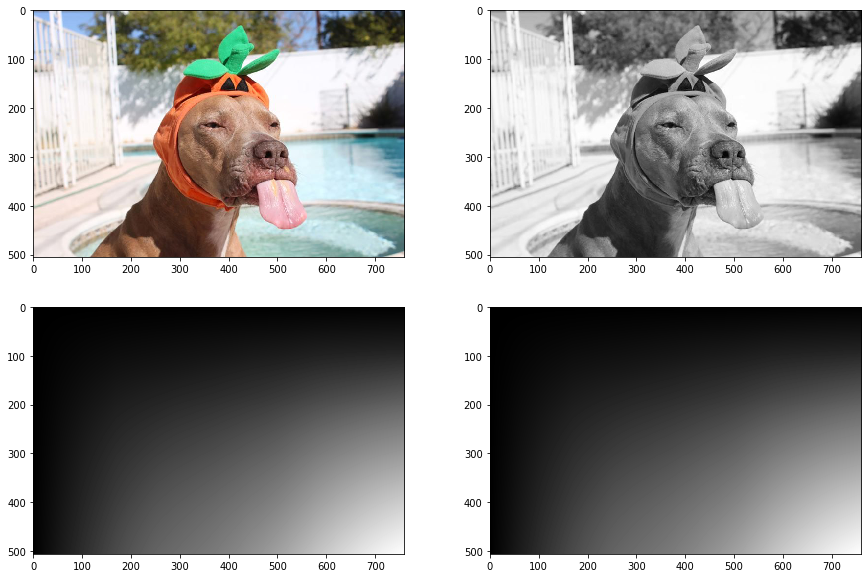

In [61]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from skimage import color, io, transform


input_image = io.imread("images/dog.jpg")
input_image_gray = color.rgb2gray(input_image)

def integral_image(img):
    h, w = shape = img.shape
    # Make matrices bigger so we don't have to have if-else for s(x, -1) = 0 and ii(-1, y) = 0
    # In the end, we just ignore those extra row and column to get back the original size.
    s = np.zeros((h + 1, w + 1))
    ii = np.zeros((h + 1, w + 1))
    for y in range(1, h + 1):
        for x in range(1, w + 1):
            s[y, x] = s[y - 1, x] + img[y - 1, x - 1]
            ii[y, x] = ii[y, x - 1] + s[y, x]
    return ii[1:, 1:]


ii_self = integral_image(input_image_gray)
ii_skimage = transform.integral_image(input_image_gray)

print('Are the 2 integral images equal?', 'Yes.' if np.all(ii_self == ii_skimage) else 'No.')


fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax21 = plt.subplot(2, 2, 3)
ax22 = plt.subplot(2, 2, 4)

ax11.imshow(input_image)
ax12.imshow(input_image_gray, cmap='gray')
ax21.imshow(ii_self, cmap='gray')
ax22.imshow(ii_skimage, cmap='gray')


None

# Ex. 6.3 AdaBoosting
Implement the AdaBoost algorithm as outlined in the paper. Train a 20-feature classifier using these datasets: 
    
faces and non-faces:    www.ai.mit.edu/courses/6.899/lectures/faces.tar.gz

Test your classifier with different thesholds and visualize the ROC curve **(RESULTS)**

In [138]:
from abc import abstractmethod
import copyreg

import numpy as np


class Model:
    @abstractmethod
    def fit(self, X_train, y_train):
        """
        :param X_train: np.array shape=(N, M) Input matrix
        :param y_train: np.array shape=(N,)   Labels for inputs such that X_i -> y_i
        
        Uses training data for fit the model.
        """
    
    @abstractmethod
    def predict(self, X):
        """
        :param X: np.array (K, M) Input matrix to predict labels for.
        
        Returns labels (given as y_train in self.fit) for all x in X.
        """
    
    def get_confusion_matrix(self, X_test, y_test):
        classes = np.unique(y_test)
        matrix = np.zeros(shape=(classes, classes))
        for i, x in enumerate(X_test):
            given_label = y_test[i]
            given_label_index = np.where(classes == given_label)[0]
            predicted_label = self.predict(x)
            predicted_label_index = np.where(classes == predicted_label)[0]
            matrix[given_label_index][predicted_label_index] += 1
        return matrix
    
    def get_score(self, X_test, y_test, print_score=True, print_confusion_matrix=False):
        matrix = self.get_confusion_matrix(X_test, y_test)
        score = np.sum(np.diag(matrix)) / len(X_test)
        if print_confusion_matrix:
            print('confusion matrix =', matrix)
        if print_score:
            print('accuracy =', score)
        return score

    
class AdaBoost(Model):
    def __init__(self, *, T):
        self.T = T
        
    def fit(self, X_train, y_train):
        return

    def predict(self, X):
        pass

    
class Feature:
    """
    Pickable feature using an integral-image lookup for fast computation.
    """
    
    def __init__(self, white_rect, black_rect):
        self.white_rect = white_rect
        self.black_rect = black_rect
    
    @staticmethod
    def pickle(instance):
        return Feature, (instance.white_rect, instance.black_rect)
    
    def __call__(self, ii):
        white, black = self.white_rect, self.black_rect
        # print(white, black)
        return (
            (ii[white[3]] + ii[white[0]] - ii[white[1]] - ii[white[2]])
            - (ii[black[3]] + ii[black[0]] - ii[black[1]] - ii[black[2]])
        )

copyreg.pickle(Feature, Feature.pickle)
        

def convert_mask_feature_to_integral_lookups(x, y, feature):
    """
    :param feature: np.array A bound feature (see doctstring below).
    
    A factory for as-in-the-paper features from the features we generated in ex6.1
    (2-rect only!).
    """
    fh, fw = feature.shape
    is_vertical = feature[0, 0] != feature[0, -1]
    white_first = feature[0, 0] == 1

    # NOTE: The order of corners is like in the paper (tl, tr, bl, br).
    if is_vertical:
        white_rect = (
            (y, x),
            (y, x + fw/2),
            (y + fh, x),
            (y + fh, x + fw/2),
        )
        black_rect = (
            (y, x + fw/2),
            (y, x + fw),
            (y + fh, x + fw/2),
            (y + fh, x + fw),
        )
        if not white_first:
            white_rect, black_rect = black_rect, white_rect
    else:
        white_rect = (
            (y, x),
            (y, x + fw),
            (y + fh/2, x),
            (y + fh/2, x + fw),
        )
        black_rect = (
            (y + fh/2, x),
            (y + fh/2, x + fw),
            (y + fh, x + fw),
            (y + fh, x + fw),
        )
        if not white_first:
            white_rect, black_rect = black_rect, white_rect
    
    # NOTE: lambda functions are not pickable, thus not usable with pool.map!
    #       Therefore, we use a custom class that we made pickable manually.
    # return lambda ii: (
    #     (ii[white_rect[3]] + ii[white_rect[0]] - ii[white_rect[1]] - ii[white_rect[2]])
    #     - (ii[black_rect[3]] + ii[black_rect[0]] - ii[black_rect[1]] - ii[black_rect[2]])
    # )
    return Feature(np.array(white_rect, dtype=np.uint), np.array(black_rect, dtype=np.uint))
    
    
def combinated_ii_features(features, height, width):
    """
    Generates all possible combinations of general features with possible pixel positions.
    Let's call these 'bound features'.
    Also converts all of these into function that perform lookups in the integral image (ii).
    Thus, this function returns features as meant in the paper.
    """
    results = []
    for y in range(height):
        for x in range(width):
            for feature in features:
                fh, fw = feature.shape
                if x + fw <= width and y + fh <= height:
                    results.append(
                        convert_mask_feature_to_integral_lookups(x, y, feature)
                    )
    return results
    

In [139]:
from multiprocessing import Pool

import numpy as np
from skimage import io, transform


# For now only select a few images.
faces = io.imread_collection("images/faces/train/face/face000*")
non_faces = io.imread_collection("images/faces/train/non-face/B1_000*")

# NOTE: All following notation as in the paper.

l, m = len(faces), len(non_faces)
N = n = l + m
T = 3
print(f'read {n} images.')

X_train = np.concatenate((np.array(faces), np.array(non_faces)))
y_train = np.concatenate((np.ones((l,)), np.zeros(m,)))
print('prepared training data.')

height, width = faces[0].shape
two_rect_features = construct_features(width, height)
print(f'generated {len(two_rect_features)} features.')
features = combinated_ii_features(two_rect_features, height, width)
print(f'generated {len(features)} bound features.')
# print(len(features))
# 172800

with Pool() as pool:
    integral_images = pool.map(transform.integral_image, X_train)
    print(f'generated integral {len(integral_images)} images.')
    # integral_images = transform.integral_image(input_image_gray)

read 198 images.
prepared training data.
generated 684 features.
generated 68400 bound features.
generated integral 198 images.


In [140]:
from dataclasses import dataclass, astuple
from typing import Callable

import numpy as np


weights = np.zeros((n,))
weights[:l] = 1 / (2 * l)
weights[l:] = 1 / (2 * m)
# print(weights)

y_indices_neg = np.where(y_train == 0)
y_indices_pos = np.where(y_train == 1)

weak_classifiers = []


@dataclass
class Params:
    """
    In the paper: f_t, theta_t, p_t, epsilon_t
    """
    feature: Callable
    threshold: int = -1
    parity_bit: int = 1
    error: np.double = -1


def optimize_params_for_feature(feature, X_train, y_train, weights, iis):
    params = Params(feature)

    # Sort computed feature values bound to their original indices 
    # so that their originally assigned weights can still be associated.
    feature_values = np.array(sorted(
        [(idx, feature(ii)) for idx, ii in enumerate(iis)],
        key=lambda tup: tup[1]
    ))
    # TODO: Maybe precompute integral sums?
    # distinct_thresholds = np.unique(feature_values[:, 1])
    # N = len(distinct_thresholds)
    for thresh in range(N):
        left_partition = feature_values[:thresh + 1]
        indices = left_partition[:, 0]
        # Find the original indices for positive and negative samples
        # for the left partition.
        neg = np.intersect1d(indices, y_indices_neg)
        pos = np.intersect1d(indices, y_indices_pos)

        S_p = np.sum(pos_sample_weights[pos])
        S_n = np.sum(neg_sample_weights[neg])
        # page 20 from lecture (left -> h=0, right -> h=1)
        error_01 = S_p + T_n - S_n
        # page 21 from lecture (left -> h=1, right -> h=0)
        error_10 = S_n + T_p - S_p
        if error_01 <= error_10:
            parity_bit = 1
            error = error_01
        else:
            parity_bit = 0
            error = error_10
        # error = min(error_01, error_10)
        if error < params.error:
            params.threshold = thresh
            params.parity_bit = parity_bit
            params.error = error
    print('.', end='')
    return astuple(params)


def create_best_weak_classifier(X_train, y_train, weights, features, iis):
    # NOTE: All weights stay the same during this function call.
    pos_sample_weights, neg_sample_weights = weights[y_train == 1], weights[y_train == 0]
    T_n = np.sum(neg_sample_weights)
    
    with Pool() as pool:
        params = pool.starmap(
            optimize_params_for_feature,
            [(feature, X_train, y_train, weights, iis) for feature in features]
        )


for t in range(T):
    # 1. Normalize the weights
    weights = weights / np.sum(weights)
    h_t = create_best_weak_classifier(X_train, y_train, weights, features, iis=integral_images)
    weak_classifiers.append(h_t)

[[0 0]
 [0 1]
 [1 0]
 [1 1]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]
[[0 0]
 [0 1]
 [1 0]
 [1 1]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]
[[0 0]
 [0 1]
 [1 0]
 [1 1]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]
[[0 0]
 [0 1]
 [1 0]
 [1 1]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]
[[0 0]
 [0 1]
 [1 0]
 [1 1]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]
[[0 0]
 [0 1]
 [1 0]
 [1 1]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]
[[0 0]
 [0 1]
 [1 0]
 [1 1]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]
[[0 0]
 [0 1]
 [1 0]
 [1 1]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]
[[0 0]
 [0 1]
 [1 0]
 [1 1]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]
[[0 0]
 [0 1]
 [1 0]
 [1 1]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]
[[0 0]
 [0 1]
 [1 0]
 [1 1]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]
[[0 0]
 [0 1]
 [1 0]
 [1 1]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]
[[0 0]
 [0 1]
 [1 0]
 [1 1]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]
[[0 0]
 [0 1]
 [1 0]
 [1 1]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]
[[0 0]
 [0 1]
 [1 0]
 [1 1]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]
[[0 0]
 [0 1]
 [1 0]
 [1 1]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]
[[0 0]
 [0 1]
 [1 0]
 [1 1]][[ 6  7]
 [ 6 15]
 [12 15]
 [12 15]] [[1 0]


 [2 1]]
[[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]]
[[0 0]
 [0 1]
 [1 0]
 [1 1]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]
[[ 1  2]
 [ 1 18]
 [ 9  2]
 [ 9 18]]
[[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]] [[ 9  2]
 [ 9 18]
 [17 18]
 [17 18]][[0 0]
 [0 1]
 [1 0]
 [1 1]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]]
 [[1 0]
 [1 1]
 [2 1]
 [2 1]]
[[ 1  2]
 [ 1 18]
 [ 9  2]
 [ 9 18]] [[ 0  7]
 [ 0 15]
 [ 6  7]
 [ 6 15]] [[ 9  2]
 [ 9 18]
 [17 18]
 [17 18]]

[[ 1  2]
 [ 1 18]
 [ 9  2]
 [ 9 18]] [[ 9  2]
 [ 9 18]
 [17 18]
 [17 18]]
[[ 1  2]
 [ 1 18]
 [ 9  2]
 [ 9 18]] [[ 9  2]
 [ 9 18]
 [17 18]
 [17 18]]
[[ 6  7]
 [ 6 15]
 [12 15]
 [12 15]] [[ 0  7]
 [ 0 15]
 [ 6  7]
 [ 6 15]][[ 1  2]
 [ 1 18]
 [ 9  2]
 [ 9 18]] [[ 9  2]
 [ 9 18]
 [17 18]
 [17 18]]

[[ 1  2]
 [ 1 18]
 [ 9  2]
 [ 9 18]][[ 6  7]
 [ 6 15]
 [12 15]
 [12 15]] [[ 0  7]
 [ 0 15]
 [ 6  7]
 [ 6 15]] [[ 9  2]
 [ 9 18]
 [17 18]
 [17 18]]

[[ 6  7]
 [ 6 15]
 [12 15]
 [12 15]][[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]][[ 1  2]
 [ 1 18]
 [ 9  2]

 [1 1]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]]
 [[1 0]
 [1 1]
 [2 1]
 [2 1]]
[[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]][[0 0]
 [0 1]
 [1 0]
 [1 1]]
 [[1 0]
 [1 1]
 [2 1]
 [2 1]][[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]]
 [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]][[0 0]
 [0 1]
 [1 0]
 [1 1]]
 [[1 0]
 [1 1]
 [2 1]
 [2 1]]
[[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]][[0 0]
 [0 1]
 [1 0]
 [1 1]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]

[[0 0]
 [0 1]
 [1 0]
 [1 1]][[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]

[[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]][[0 0]
 [0 1]
 [1 0]
 [1 1]][[ 6  7]
 [ 6 15]
 [12 15]
 [12 15]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]]
 [[1 0]
 [1 1]
 [2 1]
 [2 1]]
[[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]][[0 0]
 [0 1]
 [1 0]
 [1 1]]
 [[1 0]
 [1 1]
 [2 1]
 [2 1]]
 [[ 0  7]
 [ 0 15]
 [ 6  7]
 [ 6 15]][[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]][[0 0]
 [0 1]
 [1 0]
 [1

 [1 1]]
[[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]] [[1 0]
 [1 1]
 [2 1]
 [2 1]][[ 6  7]
 [ 6 15]
 [12 15]
 [12 15]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]]
[[ 1  2]
 [ 1 18]
 [ 9  2]
 [ 9 18]][[0 0]
 [0 1]
 [1 0]
 [1 1]]
 [[ 0  7]
 [ 0 15]
 [ 6  7]
 [ 6 15]]
[[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]] [[1 0]
 [1 1]
 [2 1]
 [2 1]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]][[ 6  7]
 [ 6 15]
 [12 15]
 [12 15]]

 [[ 0  7]
 [ 0 15]
 [ 6  7]
 [ 6 15]][[0 0]
 [0 1]
 [1 0]
 [1 1]]
 [[ 9  2]
 [ 9 18]
 [17 18]
 [17 18]]
[[ 1  2]
 [ 1 18]
 [ 9  2]
 [ 9 18]][[ 6  7]
 [ 6 15]
 [12 15]
 [12 15]] [[ 9  2]
 [ 9 18]
 [17 18]
 [17 18]]
[[ 1  2]
 [ 1 18]
 [ 9  2]
 [ 9 18]] [[ 9  2]
 [ 9 18]
 [17 18]
 [17 18]]
[[ 1  2]
 [ 1 18]
 [ 9  2]
 [ 9 18]] [[ 0  7]
 [ 0 15]
 [ 6  7]
 [ 6 15]] [[ 9  2]
 [ 9 18]
 [17 18]
 [17 18]]
 [[1 0]
 [1 1]
 [2 1]
 [2 1]]
[[ 6  7]
 [ 6 15]
 [12 15]
 [12 15]][[ 1  2]
 [ 1 18]
 [ 9  2]
 [ 9 18]]
 [[ 0  7]
 [ 0 15]
 [ 6  7]
 [ 6 15]]
 [[ 9  2]
 [ 9 18]
 [17 18]
 [17 18]][[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 1

 [2 1]][[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]]

[[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]][[0 0]
 [0 1]
 [1 0]
 [1 1]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]

[[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]][[0 0]
 [0 1]
 [1 0]
 [1 1]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]
 [[ 0  7]
 [ 0 15]
 [ 6  7]
 [ 6 15]][[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]]
 [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]][[0 0]
 [0 1]
 [1 0]
 [1 1]]
 [[1 0]
 [1 1]
 [2 1]
 [2 1]][[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]]

[[0 0]
 [0 1]
 [1 0]
 [1 1]]
[[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]][[ 6  7]
 [ 6 15]
 [12 15]
 [12 15]] [[1 0]
 [1 1]
 [2 1]
 [2 1]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]]

 [[ 0  7]
 [ 0 15]
 [ 6  7]
 [ 6 15]][[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]][[0 0]
 [0 1]
 [1 0]
 [1 1]]
 [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]

[[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]][[ 6  7]
 [ 6 15]
 [12 15]
 [12 15]]

 [ 3 16]]

[[0 0]
 [0 1]
 [1 0]
 [1 1]]
[[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]
 [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]]
[[0 0]
 [0 1]
 [1 0]
 [1 1]][[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]] [[1 0]
 [1 1]
 [2 1]
 [2 1]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]]

[[0 0]
 [0 1]
 [1 0]
 [1 1]][[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]] [[1 0]
 [1 1]
 [2 1]
 [2 1]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]]

[[0 0]
 [0 1]
 [1 0]
 [1 1]][[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]] [[1 0]
 [1 1]
 [2 1]
 [2 1]]
 [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]] [[ 9  2]
 [ 9 18]
 [17 18]
 [17 18]]
[[0 0]
 [0 1]
 [1 0]
 [1 1]][[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]] [[1 0]
 [1 1]
 [2 1]
 [2 1]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]]
[[ 6  7]
 [ 6 15]
 [12 15]
 [12 15]]
[[0 0]
 [0 1]
 [1 0]
 [1 1]]
 [[1 0]
 [1 1]
 [2 1]
 [2 1]][[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]]
 [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]][[0 0]
 [0 1]
 [1 0]
 [1 1]]
 [[1 0]
 [1 1]
 [2 1]
 [2 1]][[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]]
 [[ 0  7]
 [ 0 15]
 [ 6  7]


 [ 3 16]][[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]]
 [[ 0  7]
 [ 0 15]
 [ 6  7]
 [ 6 15]] [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]][[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]]
 [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]]

[[ 6  7]
 [ 6 15]
 [12 15]
 [12 15]][[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]][[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]] [[ 0  7]
 [ 0 15]
 [ 6  7]
 [ 6 15]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]] [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]]


[[ 6  7]
 [ 6 15]
 [12 15]
 [12 15]][[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]][[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]] [[ 0  7]
 [ 0 15]
 [ 6  7]
 [ 6 15]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]]
 [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]][[ 1  2]
 [ 1 18]
 [ 9  2]
 [ 9 18]]
[[ 6  7]
 [ 6 15]
 [12 15]
 [12 15]][[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]]
 [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]] [[ 0  7]
 [ 0 15]
 [ 6  7]
 [ 6 15]][[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]]

 [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]][[ 6  7]
 [ 6 15]
 [12 15]
 [12 15]]
[[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]][[ 2  6]
 [ 2 11]
 [17  6]
 [1

 [ 5 16]][[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]] [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]]

[[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]]
[[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]] [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]]

[[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]][[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]] [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]]

[[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]] [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]]
[[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]] [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]]
[[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]] [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]][[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]]
[[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]] [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]]
 [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]][[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]] [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]]

[[ 3 13]
 [ 3 16]
 [ 5 16]
 [ 5 16]] [[ 1 13]
 [ 1 16]
 [ 3 13]
 [ 3 16]][[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]]
 [[ 2 11]
 [ 2 16]
 [17 11]


 [7 5]] [[ 4  5]
 [ 4 10]
 [ 7  5]
 [ 7 10]][[ 6 11]
 [ 6 13]
 [ 8 13]
 [ 8 13]] [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13]]

[[4 0]
 [4 5]
 [7 0]
 [7 5]][[ 6 11]
 [ 6 13]
 [ 8 13]
 [ 8 13]] [[ 4  5]
 [ 4 10]
 [ 7  5]
 [ 7 10]]
 [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]] [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13]]
[[4 0]
 [4 5]
 [7 0]
 [7 5]] [[ 4  5]
 [ 4 10]
 [ 7  5]
 [ 7 10]]
[[ 6 11]
 [ 6 13]
 [ 8 13]
 [ 8 13]]
 [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13]][[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]]
[[4 0]
 [4 5]
 [7 0]
 [7 5]] [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]] [[ 4  5]
 [ 4 10]
 [ 7  5]
 [ 7 10]]
[[ 6 11]
 [ 6 13]
 [ 8 13]
 [ 8 13]]
 [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13]]
[[ 6 11]
 [ 6 13]
 [ 8 13]
 [ 8 13]][[4 0]
 [4 5]
 [7 0]
 [7 5]] [[ 4  5]
 [ 4 10]
 [ 7  5]
 [ 7 10]] [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13]]
[[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]]
[[ 6 11]
 [ 6 13]
 [ 8 13]
 [ 8 13]] [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]][[4 0]
 [4 5]
 [7 0]
 [7 5]] [[ 4  5]
 [ 4 10]
 [ 7  5]
 [ 7 10]] [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13

 [7 5]] [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13]] [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]] [[ 6  5]
 [ 6  9]
 [18  5]
 [18  9]] [[ 4  5]
 [ 4 10]
 [ 7  5]
 [ 7 10]]


[[ 6  9]
 [ 6 13]
 [18  9]
 [18 13]][[ 6 11]
 [ 6 13]
 [ 8 13]
 [ 8 13]] [[ 6  5]
 [ 6  9]
 [18  5]
 [18  9]] [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13]]

[[ 6  9]
 [ 6 13]
 [18  9]
 [18 13]][[ 6 11]
 [ 6 13]
 [ 8 13]
 [ 8 13]] [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13]]
 [[ 6  5]
 [ 6  9]
 [18  5]
 [18  9]][[ 6 11]
 [ 6 13]
 [ 8 13]
 [ 8 13]]
 [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13]][[ 6  9]
 [ 6 13]
 [18  9]
 [18 13]]
 [[ 6  5]
 [ 6  9]
 [18  5]
 [18  9]][[ 6 11]
 [ 6 13]
 [ 8 13]
 [ 8 13]]
 [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13]][[ 6  9]
 [ 6 13]
 [18  9]
 [18 13]]
 [[ 6  5]
 [ 6  9]
 [18  5]
 [18  9]][[ 6 11]
 [ 6 13]
 [ 8 13]
 [ 8 13]] [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13]]


[[ 6  9]
 [ 6 13]
 [18  9]
 [18 13]][[ 6 11]
 [ 6 13]
 [ 8 13]
 [ 8 13]] [[ 6  5]
 [ 6  9]
 [18  5]
 [18  9]] [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13]]

[[ 6  9]
 [ 6 13]
 [18  9]


 [7 5]]
 [[ 4  5]
 [ 4 10]
 [ 7  5]
 [ 7 10]][[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]]
 [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]][[4 0]
 [4 5]
 [7 0]
 [7 5]]
 [[ 4  5]
 [ 4 10]
 [ 7  5]
 [ 7 10]][[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]]
 [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]][[4 0]
 [4 5]
 [7 0]
 [7 5]]
 [[ 4  5]
 [ 4 10]
 [ 7  5]
 [ 7 10]][[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]]
 [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]]
[[4 0]
 [4 5]
 [7 0]
 [7 5]]
[[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]] [[ 4  5]
 [ 4 10]
 [ 7  5]
 [ 7 10]] [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]][[ 6  9]
 [ 6 13]
 [18  9]
 [18 13]]

[[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]][[4 0]
 [4 5]
 [7 0]
 [7 5]] [[ 6  5]
 [ 6  9]
 [18  5]
 [18  9]] [[ 4  5]
 [ 4 10]
 [ 7  5]
 [ 7 10]] [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]]


[[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]][[ 6  9]
 [ 6 13]
 [18  9]
 [18 13]][[4 0]
 [4 5]
 [7 0]
 [7 5]] [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]] [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13]] [[ 6  5]
 [ 6  9]
 [18  5]
 [18  9]] [[ 4  5]
 [ 4 10]
 [ 7  5]
 [ 7 1

 [17 16]][[4 0]
 [4 5]
 [7 0]
 [7 5]] [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13]] [[ 6  5]
 [ 6  9]
 [18  5]
 [18  9]]

 [[ 4  5]
 [ 4 10]
 [ 7  5]
 [ 7 10]]
[[ 6 11]
 [ 6 13]
 [ 8 13]
 [ 8 13]][[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]][[ 6  9]
 [ 6 13]
 [18  9]
 [18 13]]
 [[ 6  5]
 [ 6  9]
 [18  5]
 [18  9]] [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13]] [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]][[4 0]
 [4 5]
 [7 0]
 [7 5]]


[[ 6 11]
 [ 6 13]
 [ 8 13]
 [ 8 13]] [[ 4  5]
 [ 4 10]
 [ 7  5]
 [ 7 10]][[ 6  9]
 [ 6 13]
 [18  9]
 [18 13]][[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]] [[ 6  5]
 [ 6  9]
 [18  5]
 [18  9]] [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13]]

 [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]]
[[4 0]
 [4 5]
 [7 0]
 [7 5]][[ 6 11]
 [ 6 13]
 [ 8 13]
 [ 8 13]]
[[ 6  9]
 [ 6 13]
 [18  9]
 [18 13]] [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13]] [[ 4  5]
 [ 4 10]
 [ 7  5]
 [ 7 10]] [[ 6  5]
 [ 6  9]
 [18  5]
 [18  9]]
[[ 2  6]
 [ 2 11]
 [17  6]
 [17 11]]
 [[ 2 11]
 [ 2 16]
 [17 11]
 [17 16]][[4 0]
 [4 5]
 [7 0]
 [7 5]]
[[ 2  6]
 [ 2 11]
 [17 

 [ 7 10]] [[ 6  5]
 [ 6  9]
 [18  5]
 [18  9]]

[[ 6  9]
 [ 6 13]
 [18  9]
 [18 13]] [[ 6  5]
 [ 6  9]
 [18  5]
 [18  9]]

 [[ 4  5]
 [ 4 10]
 [ 7  5]
 [ 7 10]][[ 6 11]
 [ 6 13]
 [ 8 13]
 [ 8 13]][[ 6  9]
 [ 6 13]
 [18  9]
 [18 13]]
 [[ 6  5]
 [ 6  9]
 [18  5]
 [18  9]] [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13]]
[[4 0]
 [4 5]
 [7 0]
 [7 5]][[ 6 11]
 [ 6 13]
 [ 8 13]
 [ 8 13]] [[ 4  5]
 [ 4 10]
 [ 7  5]
 [ 7 10]] [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13]]

[[4 0]
 [4 5]
 [7 0]
 [7 5]][[ 6 11]
 [ 6 13]
 [ 8 13]
 [ 8 13]]
 [[ 4  5]
 [ 4 10]
 [ 7  5]
 [ 7 10]] [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13]]

[[4 0]
 [4 5]
 [7 0]
 [7 5]][[ 6 11]
 [ 6 13]
 [ 8 13]
 [ 8 13]] [[ 4  5]
 [ 4 10]
 [ 7  5]
 [ 7 10]] [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13]]

[[4 0]
 [4 5]
 [7 0]
 [7 5]][[ 6 11]
 [ 6 13]
 [ 8 13]
 [ 8 13]] [[ 4  5]
 [ 4 10]
 [ 7  5]
 [ 7 10]] [[ 4 11]
 [ 4 13]
 [ 6 11]
 [ 6 13]]

[[4 0]
 [4 5]
 [7 0]
 [7 5]][[ 6  9]
 [ 6 13]
 [18  9]
 [18 13]][[ 6 11]
 [ 6 13]
 [ 8 13]
 [ 8 13]] [[ 4  5]
 [ 4 10]
 [ 7  5]
 [ 

 [16 18]]

 [[12  9]
 [12 14]
 [17  9]
 [17 14]]
[[16  4]
 [16 18]
 [18 18]
 [18 18]][[ 9  7]
 [ 9 16]
 [12  7]
 [12 16]][[12  4]
 [12  9]
 [17  4]
 [17  9]] [[14  4]
 [14 18]
 [16  4]
 [16 18]] [[12  7]
 [12 16]
 [15 16]
 [15 16]]
 [[12  9]
 [12 14]
 [17  9]
 [17 14]]
[[16  4]
 [16 18]
 [18 18]
 [18 18]]
 [[14  4]
 [14 18]
 [16  4]
 [16 18]][[12  4]
 [12  9]
 [17  4]
 [17  9]]
[[ 9  7]
 [ 9 16]
 [12  7]
 [12 16]][[ 7  5]
 [ 7 12]
 [ 9  5]
 [ 9 12]] [[12  9]
 [12 14]
 [17  9]
 [17 14]] [[12  7]
 [12 16]
 [15 16]
 [15 16]]
[[16  4]
 [16 18]
 [18 18]
 [18 18]]
 [[ 9  5]
 [ 9 12]
 [11 12]
 [11 12]] [[14  4]
 [14 18]
 [16  4]
 [16 18]][[12  4]
 [12  9]
 [17  4]
 [17  9]][[ 9  7]
 [ 9 16]
 [12  7]
 [12 16]]
 [[12  9]
 [12 14]
 [17  9]
 [17 14]][[16  4]
 [16 18]
 [18 18]
 [18 18]] [[12  7]
 [12 16]
 [15 16]
 [15 16]]


 [[14  4]
 [14 18]
 [16  4]
 [16 18]][[12  4]
 [12  9]
 [17  4]
 [17  9]]
[[ 9  7]
 [ 9 16]
 [12  7]
 [12 16]] [[12  9]
 [12 14]
 [17  9]
 [17 14]][[ 7  5]
 [ 7 12]
 [ 9  5]
 

In [109]:
s = 19
n = 0
for x in range(24):
    for y in range(24):
        a = s - x
        b = s - y
        v = (a // 2) * b
        h = (b // 2) * a
        n += 2*(v + h)
print(n)

60480
